<!---
layout: post
title: Dynamic Message Passing and the "Echo Chamber" Effect
mathjax: true
tags: 
- Python
- Network Analysis
- Dynamic Message Passing
- Echo Chamber Effect
--->

# Dynamic Message Passing and the "Echo Chamber" Effect

The modeling of epidemic spreading has many practical applications - from disease epidemiology to the spread of online rumors. Traditional approaches like the classical SIR model assume a "fully mixed" population where interaction between any two individuals is equally likely. These models are popular because they admit simple equations that provide a good general guide to population-level spread dynamics.

However, contacts between individuals generally differ a lot - some pairs interact more than others. Network epidemiology builds on the traditional approaches by assuming individuals interact on a network that reflects more realistic mixing patterns. But there is a cost - relaxing the fully mixed assumption substantially increases model complexity. For example, computing the infection probabilities of each node over time requires keeping track of the entire joint distribution of nodes. With $n$ individuals that can each be in one of $k$ states, the resuling system of $k^n$ variables quickly becomes computationally intractable, even on moderately sized networks. This means that we generally have to resort to expensive Monte Carlo simulations. A lot of attention has therefore focused on developing analytical approximations that can be computed quickly.

But naive approximation methods based on straightforward SIR-type equations suffer from the "Echo Chamber" effect, where pairs of adjacent nodes amplify each other's infection probability. This post begins by explaining why intuitive approaches result in this overestimation of infection risk, then implements one of the most popular analytical approaches to overcome this issue - Dynamic Message Passing (DMP) - originally developed in this context by [Karrer and Newman (2010)](https://arxiv.org/abs/1003.5673) with a lot of subsequent work by others ([Lokhov et al. 2014](https://arxiv.org/abs/1303.5315); [Shrestha et al. 2015](https://arxiv.org/abs/1505.02192); [Koher et al. 2018](https://arxiv.org/abs/1811.05809)). We'll focus on a simple discrete time [SI model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#Variations_on_the_basic_SIR_model) on a static network in which infected nodes transmit disease to susceptible neighbors with probability $\beta$ each period, and compare estimates of the infection probabilities for each node $i$, $I_i(t)$, across three approaches - Monte Carlo simulation, a naive analytical approach, and DMP.

We'll start by creating a simple two-node network to help motivate our intuition. The directed network is represented as a simple two column dataframe with the first and second columns giving the `source` and `target` nodes, respectively, of each directed edge (see a [previous blog post](https://hautahi.com/ic_comparison) comparing four different ways of representing networks in Python).

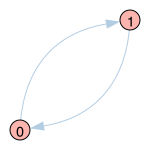

In [7]:
# Load packages
from igraph import *
import time
import pandas as pd
import numpy as np

# Create simple two-node network
g = pd.DataFrame({'source': [1, 0], 'target': [0, 1]})

# Create igraph representation and plot
p_style = {"bbox": (150, 150), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}
G = Graph(directed = True)
G.add_vertices(g['source'])
G.add_edges(zip(g['source'],g['target']))
plot(G, layout=G.layout("kk"), vertex_label = G.vs["name"], **p_style)

## Monte Carlo Approach

The following function computes the infection probabilities at time `t` for all nodes via Monte Carlo simulation. In each of `mc` iterations we first draw the initially infected nodes according to their initial infection probabilities stored in the two-column `I0` dataframe. We then simulate the spread dynamics for `t` time periods by first drawing each edge with probability `beta` and then infecting `target` nodes if the `source` node of the remaining edges are infected. The `infected` dictionary at the end of a single MC simulation indicates whether or not a given node is infected. These are then added to a running count across all MC simulations in the `total_infected_count` dictionary, which, after dividing by `mc`, represent the infection probability of each node. The function returns these estimates as a two column dataframe.

In [8]:
def SI_MC(g, I0, beta, t, mc = 10000):  

    # Get id and initial infection probabilities for each node
    start, nodes, init_probs = time.time(), I0['node'].tolist(), I0['prob'].tolist()

    # Dic to store total times each node is infected at t across all MC simulations
    total_infected_count = dict.fromkeys(nodes, 0)
    
    # Perform Monte Carlo simulations
    for _ in range(mc):

        # Randomly draw initially infected nodes for this MC iteration
        success  = np.random.uniform(0,1,len(init_probs)) < init_probs
        infected = dict.fromkeys(nodes,0)
        infected.update(dict.fromkeys(np.extract(success, nodes), 1))
        
        # Compute spread dynamics over time
        for _ in range(t):

            # Get transmitting edges 
            tmp = g.loc[np.random.uniform(0,1,g.shape[0]) < beta]
            
            # Set node status dictionary to update
            new_infected = infected.copy()

            # Go through each edge
            for f1, f2 in zip(tmp['source'],tmp['target']):

                # Send an infection if infected
                if infected[f1]: new_infected[f2] = 1
                    
            # Update the infected dictionary
            infected = new_infected.copy()

        # Add to running count across MC simulations
        for node in total_infected_count.keys():
            total_infected_count[node] += infected[node]

    # Compute resulting probs by dividing by number of MC iterations
    I = {k: v / mc for k, v in total_infected_count.items()}

    # Save results in dataframe
    estimates = pd.DataFrame(I.items(), columns = ['node', 'I(t)_mc'])
    print("MC Runtime:    " + str(round(time.time() - start,2)) + " seconds")
    
    return(estimates.round({'I(t)_mc': 2}))

Running the Monte Carlo simulation on our simple 2-node network for $t=4$ periods with $\beta = 0.2$ and initial probabilities of $I_0(0)=0.4$ and $I_1(0)=0$ produces estimates of $I_0(4)=0.4$ and $I_1(4)=0.24$. In this extremely simple case we can confirm these values to be true. Given the disease only arises in the system with probability 0.4, which can only happen at node 0, we know trivially that $I_0(4)$ must be $0.4$. And if node 0 is initially infected, then it has four chances to infect node 1, and therefore does not infect node 1 with probability $(1-0.2)^4$. This implies that node 1 is infected with probability $1-[0.6+0.4\times(1-0.2)^4]=0.24$.

In [9]:
# Set initial infection probabilities
I0 = pd.DataFrame({'node': [0,1], 'prob': [0.4, 0]})

# Set parameters
beta, t = 0.2, 4

# Run MC function
results_mc = SI_MC(g, I0, beta, t)

# Print results
results_mc.style.hide_index()

MC Runtime:    16.81 seconds


node,I(t)_mc
0,0.4
1,0.24


## Naive Analytical Approach

The above Monte Carlo approach can be very slow for large networks, so we'd prefer to compute the infection probabilities analytically if possible. The most intuitive way to do this is to directly model the evolution of each node in a similar fashion to the classical (fully mixed) version of the SI model. The following expressions for the the probability of being susceptible, $S_i(t)$, and the probability of infected, $I_i(t)$, of node $i$ at time $t$ should look familiar to those experienced with traditional SI models.
$$
S_i(t+1) = S_i(t) \prod_{k\in N_i} \left(1-\beta I_k(t)\right) \;\;\;\;\;\;\;\;\;\;\;\;\;\;
I_i(t+1) = I_i(t) + S_i(t) \left[1- \prod_{k\in N_i} \left(1-\beta  I_k(t)\right)\right]
$$
The probablity of $i$ being susceptible in one period is equal to the probability of it being susceptible in the previous period multiplied by the probability that it was not infected by any of its in-neighbors, denoted by the set $N_i$, in that period. Similar logic holds for the infection probability of $i$, which is equal to the infection probability in the previous period plus the probability of becoming newly infected. Given that $S_i(t) = 1 - I_i(t)$ in our simple SI setup, we actually only need one of the above equations. We'll use the latter in the function below.

The `SI_naive()` function does the same job as `SI_mc()` but using the analytical equations above. After extracting the node id's and the initial infection probabilities from `I0` it iterates over the `t` time periods (note there is no `mc` loop). The `I` dictionary storing the infection probabilities at each period is updated using the equation for $I_i(t+1)$ above, after which a dataframe of estimates is returned in the same format.

In [10]:
def SI_naive(g, I0, beta, t):
    
    # Get node id's and initial infection probs for each node
    start, nodes, init_probs = time.time(), I0['node'].tolist(), I0['prob'].tolist()

    # Create storage dictionary for node-specific infection probabilities
    I = dict(zip(nodes, init_probs))
    
    # Begin evolving the dynamic variables
    for _ in range(t):

        # Update marginal node probabilities
        I_new = I.copy()
        for node in nodes:

            # Compute product term from in-neighbors of node
            prod = 1
            for k in g.loc[(g['target'] == node)]['source'].unique():
                prod *= 1 - beta * I[k]

            # Update new infection probability
            I_new[node] = I[node] + (1 - I[node]) * (1 - prod)
        
        # Update infection storage to latest period
        I = I_new.copy()
        
    # Save results in dataframe
    estimates = pd.DataFrame(I.items(), columns = ['node', 'I(t)_naive'])
    print("Naive Runtime: " + str(round(time.time() - start, 2)) + " seconds")
    
    return(estimates.round({'I(t)_naive': 2}))

Running `SI_naive` on our simple 2-node network and merging it with our earlier results shows that the analytical formulation yields higher infection probability estimates than the Monte Carlo procedure. This is exactly the echo chamber effect. Note also that the analytical approach is about three orders of magnitude faster than the Monte Carlo approach, which is our motivation for avoiding Monte Carlo in the first place.

In [12]:
# Run naive analytical approximation
results_naive = SI_naive(g, I0, beta, t)

# Print results
results_mc.merge(results_naive, on = 'node').style.hide_index()

Naive Runtime: 0.01 seconds


node,I(t)_mc,I(t)_naive
0,0.4,0.45
1,0.24,0.29


## The Echo Chamber Effect

The naive approach allows infection to pass back-and-forth between the two nodes, so that once node 1 "receives" some infection probability, it passes it back to node 0, which further amplifies the infection probability of node 0, and so on in a self-enforcing "echo chamber". But we know this must be wrong because infection can only arise in the system at node 0, so any infection received from its neighbors must have originated with it. To be more formal, in our simple two-node example the equations above reduce to the following:

$$
\begin{align}
    I_0(t+1) - I_0(t) &= \beta S_0(t)I_1(t)\\
    I_1(t+1) - I_1(t) &= \beta S_1(t)I_0(t)
\end{align}
$$

which imply that the infection probability will continue to grow until $I_i(t) = 1$ for at least one node. In other words, the equations guarantee that the nodes will eventually becomes infectious, even though with probability $0.6$ there is no infection in the system at all.

This phenomenon surprised me a lot when I first encountered it, because the equations seem so intuitive and in line with how we model traditional SI models. So what is wrong with them? The key (but subtle) issue is that they do not account for correlations between the states of adjacent nodes, and therefore do not recognize that node 1 cannot be infected without node 0 being infected. In the above, the state of adjacent nodes is only accounted for via the infection probabilities of those neigboring nodes (in the $\prod_{k\in N_i} \left(1-\beta  I_k(t)\right)$ term). But often the infection probability of a node is *conditional on the state* of a neighboring node, not just on its infection probability. So we need to keep track of the joint distribution of the nodes across states.

In our case, this means explicitly modeling the joint probabilities of the set of four possible states of the network $\{(I, I), (S, S), (I, S), (S, I)\}$. To begin, we know $P(S,I) = 0$ because it's impossible for node 1 to be infected without node 0 being infected. Similarly, we know $P(S,S)=0.6$ because node 0 is susceptible with probability 0.6 and in that case cannot infect node 1. For the outcome $(I,S)$ we know that node 0 must initially be infected and that it must not pass on the infection to node 1 after $t=4$ attempts, therefore $P(I,S)=0.4\times(1-0.2)^4=0.16$. Finally, the probability that both are infected after 4 periods is $P(I,I) = 0.4\times(1-0.41) = 0.24$. We can then calculate the required marginal probabilities as follows

$$
\begin{align}
    I_0(4) = P(I,S) + P(I,I) &= 0.4\\
    I_1(4) = P(S,I) + P(I,I) &= 0.24
\end{align}
$$

which is exactly what the Monte Carlo approach above yields. To perform a similar calculation for a 3-node network requires $2^3=8$ joint probabilities, and a four-node network requires $2^4=16$ etc., which quickly gets out of hand. For example, on a smallish network with 300 nodes, there are $2\times10^{91}$ conditional probabilities, which is greater than the number of atoms in the universe. Fortunately, there is a more convenient way around this.

## Dynamic Message Passing

Dynamic Message Passing (DMP) was developed in the context of epidemic spreading by [Karrer and Newman (2010)](https://arxiv.org/abs/1003.5673) for continuous SIR models, which began a fairly active literature. For example, [Lokhov et al. (2014)](https://arxiv.org/abs/1303.5315) used DMP to infer the origin of a given epidemic in a discrete time setting, [Lokhov et al. (2015)](https://arxiv.org/abs/1407.1255) expanded their earlier work to more general unidirectional models with an arbitrary number of states, and [Shrestha et al. (2015)](https://arxiv.org/abs/1505.02192) generalized DMP to recurrent state models like SIS (they also seemed to coin the "echo chamber" term). [Wang et al. (2017)](https://arxiv.org/abs/1612.04216) provide a good summary and history of this literature within the broader context of theoretical approaches to epidemic spreading. In this post, we'll follow most closely the notation of [Koher et al. (2018)](https://arxiv.org/abs/1811.05809), although the general principles are the same for all the papers above.

The key idea is to move from a node-centric to an edge-centric focus. By keeping track of the movement of infection across edges, we can disallow an edge to transmit infection two ways and therefore help prevent the echo chamber effect. This is done by defining three new edge-specific "message" variables:

1. $\theta_{k\rightarrow i}(t)$ is the probability that the disease has not passed from $k$ to $i$ up to time $t$
2. $I_{k\rightarrow i}(t)$ is the probability that $k$ is infected at time $t$ as a result of having received the disease from a node other than $i$, and has not yet passed the infection to $i$
3. $S_{k\rightarrow i}(t)$ is the probability that $k$ has not been infected by any of its neighbors that are not $i$ up to time $t$

The definitions of the above variables take some time to chew over - they were not very intuitive to me when I first came across them. Another way to think about them is to imagine $i$ being in a "cavity" state, where it can receive but not pass on infection. In fact, DMP is often referred to as the "cavity method" for this reason. In this case, 
$S_{k\rightarrow i}(t)$ is the probability that $k$ is susceptible at time $t$ provided $i$ is in the cavity state. Because $k$ is not affected by the state of $i$, it stays susceptible if it doesn't contract the disease from any of its remaining neighbors. Similarly, $I_{k\rightarrow i}(t)$ is the probability that $k$ is infected given that $i$ is in the cavity state and was therefore infected by a neighbor other than $i$.

The probability that $i$ is susceptible at time $t$ can therefore be expressed as the probability that it was initially susceptible, $z_i = 1-I_i(0)$, multiplied by the probability that no adjacent nodes transmitted the infection up to time $t$.

$$
S_i(t) = z_i \prod_{k\in N_i}\theta_{k\rightarrow i}(t)
$$

Now we just need to describe the evolution of the three message variables. Beginning at $\theta_{k\rightarrow i}(0)=1$, the probability that the disease has not passed from $k$ to $i$ falls each period by the probability that a transmission does occur across that edge, which is equal to $\beta$ multiplied by the probability that $k$ is infected and has not earlier transmitted the disease to $i$:

$$
\theta_{k\rightarrow i}(t+1) = \theta_{k\rightarrow i}(t) -\beta I_{k\rightarrow i} (t)
$$

Beginning at $I_{k\rightarrow i}(0) = I_k(0)$, the probability that $k$ is infected and has not passed the disease to $i$ is equal to that same probability in the previous period multiplied by the probability that it did not transmit, plus the probability that it is newly infected from a non-$i$ node. This latter is equal to the reduction in $S_{k\rightarrow i}$ because, in the case of $i$ being in the cavity state, it is equal to the reduction in the probability that $k$ has not been infected by any of its non-$i$ neighbors

$$
I_{k\rightarrow i} (t+1) = (1-\beta)I_{k\rightarrow i} (t) + (S_{k\rightarrow i}(t)-S_{k\rightarrow i}(t+1))
$$

Finally, the following expression is very similar to the above for $S_{i}$ but the product term excludes the $\theta_{i\rightarrow k}$ term because it assumes that $i$ is in the cavity state. Since $k$ is not affected by the state of $i$, it stays susceptible if it doesn't contract the disease from any of its remaining incident neighbors. This can also be viewed as a conditional probability where the joint probability $S_k$ is divided by the marginal probability $\theta_{i\rightarrow k}$.


$$
S_{k\rightarrow i}(t+1) = z_k \prod_{j\in N_k\setminus i} \theta_{j\rightarrow k}(t+1)
$$

The combined effect of the above equations is that when computing the infection rate for a given node, we deliberately neglect the events where its neighbors received the infection from that node and then immediately pass it back. So the rate at which $k$ infects $i$ is proportional to the probability that $k$ was infected by a non-$i$ neighbor, which is why we only include the contribution that comes from neighbors other than $i$. 

The `SI_DMP()` function implements the above. The logic is similar to `SI_naive()` with the added complication of keeping track of the additional $3E$ message variables. The messages are stored in a dataframe `d` with a row per directed edge, which is then updated each period. Compared to `SI_naive()` there is an additional loop over each edge to compute the $S_{k\rightarrow i}$ values.

In [13]:
def SI_DMP(g,I0,beta,t): 
    
    # Get id's and initial infection probs for each node
    start, nodes, init_probs = time.time(), I0['node'].tolist(), I0['prob'].tolist()

    # Create storage dictionaries for node-specific S, I and initial probabilities
    z, I = dict(zip(nodes,[1 - x for x in init_probs])), dict(zip(nodes,init_probs))
    S = z.copy()

    # Create columns for the edge-specific (message) variables
    d, I_msg, S_msg = g.copy().drop_duplicates(), [], []
    for i, _ in zip(d['source'],d['target']):
        I_msg.append(I[i]); S_msg.append(S[i])
    d['I_msg'], d['S_msg'], d['theta'] = I_msg, S_msg, 1

    # Begin evolving the dynamic variables
    for _ in range(t):
        
        # New period messages
        d_new = d.copy()
        
        # Update theta
        d_new['theta'] -= beta * d.I_msg

        # Update S_msg
        S_msg = []
        for k, i in zip(d['source'],d['target']):

            # Get in-edges to node k excluding those originating at i
            in_edges = d_new.copy()
            in_edges = in_edges.loc[(in_edges['target'] == k) & (in_edges['source'] != i)]
            S_msg.append(z[k] * in_edges['theta'].product())

        d_new['S_msg'] = S_msg

        # Update I message
        d_new['I_msg'] = (1 - beta) * d['I_msg'] + (d['S_msg'] - d_new['S_msg'])

        # Update marginal node probabilities
        for node in nodes:

            # Susceptible
            tmp = d_new.copy()
            tmp = tmp.loc[(tmp['target'] == node)]
            S[node] = z[node] * tmp['theta'].product()

            # Infected
            I[node] = 1 - S[node]
        
        # Update dataframe to latest period
        d = d_new.copy()
        
    # Save results in dataframe
    estimates = pd.DataFrame(I.items(), columns = ['node', 'I(t)_dmp'])
    print("DMP Runtime:   " + str(round(time.time() - start, 2)) + " seconds")
    
    return(estimates.round({'I(t)_dmp': 2}))

We can now repeat our experiment on the simple two-node network above with the DMP method. DMP exactly replicates the correct estimates from the Monte Carlo code at a significant saving in computation time.

In [15]:
# Run naive analytical approximation
results_dmp = SI_DMP(g, I0, beta, t)

# Print results
results_mc.merge(results_naive,on='node').merge(results_dmp,on='node').style.hide_index()

DMP Runtime:   0.17 seconds


node,I(t)_mc,I(t)_naive,I(t)_dmp
0,0.4,0.45,0.4
1,0.24,0.29,0.24


## Experiments with Alternative Network Types

We now take a closer look at how DMP performs across five different networks generated below. The first three are simple 3-node networks with edges chosen to carefully illustrate when DMP works well and not so well. The fourth is a larger tree network to demonstrate that DMP is exact on trees. Finally we'll run our methods on a larger "more realistic" network with plenty of loops.

In [16]:
# Create three 3-node networks to help intuition
g1 = pd.DataFrame({'source': [1, 0, 1],    'target': [0, 1, 2]})
g2 = pd.DataFrame({'source': [1, 0, 0, 1], 'target': [0, 1, 2, 2]})
g3 = pd.DataFrame({'source': [1, 0, 2, 1], 'target': [0, 1, 0, 2]})

# Create a tree network (using igraph method then transforming to dataframe)
G4 = Graph.Tree(10, 2)
g4 = pd.DataFrame({'source': [x for e in G4.es for x in (e.source, e.target)],
                   'target': [x for e in G4.es for x in (e.target, e.source)]})

# Create larger "loopy" network
G5 = Graph.Barabasi(n = 40, m = 4, directed = True)
g5 = pd.DataFrame({'source': [e.source for e in G5.es],
                   'target': [e.target for e in G5.es]})

Graph 1  | Graph 2 | Graph 3 | Graph 4 | Graph 5
:-------:|:-------:|:-------:|:-------:|:-------:
![](graph1.png)| ![](graph2.png) | ![](graph3.png) | ![](graph4.png) | ![](graph5.png)

Sticking with an initial infection probability of 0.4 for node 0, the code below estimates the resulting infection probabilites for the 3-node network of Graph 1 above. This time, and for the rest of this post, we'll extend out the number of periods to $t=20$ to let the echo chamber really take effect. We see that the naive approach suffers again from the echo chamber effect resulting in overestimated infection probabilities. Node 1, after being infected by node 0, "re-infects" node 0 and so on, which in turn also raises the infection probability of node 2. The DMP approach, on the other hand, removes this mutual reinforcement between nodes 0 and 1 by only allowing node 1 to reinfect node 0 with disease it has contracted from a "non-0" in-neighbor (of which there are none in this case). So DMP achieves the exact solutions. The results also again confirm the far superior run time of the naive analytical approach compared to the Monte Carlo approach, which is hardly sacrificed when moving to the more accurate DMP approach.

In [19]:
# Set initial infection probabilities
t, I0 = 20, pd.DataFrame({'node': [0, 1, 2], 'prob': [0.4, 0, 0]})

# Run SI functions
results_mc    = SI_MC(g1, I0, beta, t)
results_naive = SI_naive(g1, I0, beta, t)
results_dmp   = SI_DMP(g1, I0, beta, t)

# Print results
results_mc.merge(results_naive,on='node').merge(results_dmp,on='node').style.hide_index()

MC Runtime:    83.84 seconds
Naive Runtime: 0.05 seconds
DMP Runtime:   0.25 seconds


node,I(t)_mc,I(t)_naive,I(t)_dmp
0,0.4,0.95,0.4
1,0.4,0.94,0.4
2,0.37,0.91,0.37


Graph 2 adds an additional edge from node 0 to 2. Although DMP gives the correct infection probabilities for nodes 0 and 1, it does not recognize that infection received by node 2 from nodes 0 and 1 originated in the same place (node 0). So it effectively treats the infection from nodes 0 and 1 as independent and therefore overestimates the infection probability for node 2 in a kind of "two-step echo chamber". Note, however, that the overestimation is always lower than the naive approach.

In [20]:
# Run SI functions
results_mc    = SI_MC(g2, I0, beta, t)
results_naive = SI_naive(g2, I0, beta, t)
results_dmp   = SI_DMP(g2, I0, beta, t)

# Print results
results_mc.merge(results_naive,on='node').merge(results_dmp,on='node').style.hide_index()

MC Runtime:    116.12 seconds
Naive Runtime: 0.06 seconds
DMP Runtime:   0.3 seconds


node,I(t)_mc,I(t)_naive,I(t)_dmp
0,0.4,0.95,0.4
1,0.4,0.94,0.4
2,0.4,0.99,0.62


Graph 3 is similar to Graph 2 except for the direction of the edge between 0 and 2. Because node 2 can only become infected via node 1, the DMP setup does not restrict the edge between 0 and 2, so 0 will receive infection from 2. Because any disease originated at 0, this means the infection probability for node 0 will be overestimated and continue to flow through the system.  This results in overstimated infection probabilities for all nodes.

In [21]:
# Run SI functions
results_mc    = SI_MC(g3, I0, beta, t)
results_naive = SI_naive(g3, I0, beta, t)
results_dmp   = SI_DMP(g3, I0, beta, t)

# Print results
results_mc.merge(results_naive,on='node').merge(results_dmp,on='node').style.hide_index()

MC Runtime:    105.64 seconds
Naive Runtime: 0.05 seconds
DMP Runtime:   0.25 seconds


node,I(t)_mc,I(t)_naive,I(t)_dmp
0,0.4,0.99,0.62
1,0.4,0.96,0.55
2,0.37,0.92,0.47


The key difference between the three networks above is that Graph 1 is a tree network, while the other two have loops. DMP methods were originally derived for tree-like networks and therefore are exact in these cases. The following code run on Graph 4 (a tree network) confirms this point (allowing for some numerical error in the Monte Carlo results).

In [22]:
# Create initial infection probabilities
I0 = pd.DataFrame({'node': g4['source'].unique(), 'prob': 0})
I0.loc[I0['node'].isin([0]), 'prob'] = 0.4

# Run SI functions
results_mc    = SI_MC(g4, I0, beta, t)
results_naive = SI_naive(g4, I0, beta, t)
results_dmp   = SI_DMP(g4, I0, beta, t)

# Print results
results_mc.merge(results_naive,on='node').merge(results_dmp,on='node').style.hide_index()

MC Runtime:    89.11 seconds
Naive Runtime: 0.16 seconds
DMP Runtime:   0.83 seconds


node,I(t)_mc,I(t)_naive,I(t)_dmp
0,0.4,1,0.4
1,0.4,1,0.4
2,0.4,1,0.4
3,0.38,1,0.37
4,0.38,0.99,0.37
5,0.38,0.95,0.37
6,0.38,0.95,0.37
7,0.32,0.9,0.32
8,0.32,0.9,0.32
9,0.32,0.89,0.32


Most networks are not trees. So the practicality of DMP methods should be assessed against whatever network is of interest. Graph 5 represents a more "normal" network based on the Barabasi model with many loops and other common real-world properties like a scale-free degree distribution. In the code below, we give four nodes the chance of being infected initially. Comparing just the first five nodes we see the now familiar pattern of the naive approach overestimating the infection probabilities with the DMP approach closer to the Monte Carlo results. We also show this by computing the average per-node difference in $I_i(t)$ between each analytical method and the MC results. The average error is much lower for DMP, as we'd expect.

In [24]:
# Create initial infection probabilities
I0 = pd.DataFrame({'node': list(set(g5['source']).union(set(g5['target']))), 'prob': 0})
I0.loc[I0['node'].isin([0,10,20,30]), 'prob'] = 0.4

# Run SI functions
t = 5 # this makes the numbers a little easier to compare
results_mc    = SI_MC(g5, I0, beta, t)
results_naive = SI_naive(g5, I0, beta, t)
results_dmp   = SI_DMP(g5, I0, beta, t)

# Print results
display(results_mc.merge(results_naive, on = 'node').merge(results_dmp, on = 'node').head().style.hide_index())

# Compute average error per node
err_naive = sum(results_naive.iloc[:, 1] - results_mc.iloc[:, 1]) / results_mc.shape[1]
err_dmp   = sum(results_dmp.iloc[:, 1] - results_mc.iloc[:, 1]) / results_mc.shape[1]

# Print average errors
print("Naive Avg Error: " + str(round(err_naive,2)))
print("DMP Avg Error:   " + str(round(err_dmp,2)))

MC Runtime:    22.31 seconds
Naive Runtime: 0.17 seconds
DMP Runtime:   1.51 seconds


node,I(t)_mc,I(t)_naive,I(t)_dmp
0,0.82,0.95,0.91
1,0.71,0.89,0.82
2,0.53,0.67,0.58
3,0.66,0.83,0.73
4,0.48,0.59,0.49


Naive Avg Error: 0.44
DMP Avg Error:   0.17


## Conclusion

We described and implemented a dynamic message passing (DMP) function in Python for a simple SI model on a static network and showed that the DMP method

- is much faster than a Monte Carlo approach
- yields identical results to Monte Carlo on tree-like networks
- reduces the echo chamber effect resulting from naive analytical approaches on all networks

The source code for this post is available at its [Github repository](https://github.com/hautahi/dmp_echo_chamber).

# Appendix: Printing the synthetic networks

The following code was use to plot and save the network images presented above.

In [40]:
# Plot settings
p_style = {"margin": 30, "bbox": (250, 250), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}

# Graph 1 igraph representation
G1 = Graph(directed = True)
G1.add_vertices(range(3))
G1.add_edges(zip(g1['source'].tolist(),g1['target'].tolist()))

# Graph 2 igraph representation
G2 = Graph(directed = True)
G2.add_vertices(range(3))
G2.add_edges(zip(g2['source'].tolist(),g2['target'].tolist()))

# Graph 3 igraph representation
G3 = Graph(directed = True)
G3.add_vertices(range(3))
G3.add_edges(zip(g3['source'].tolist(),g3['target'].tolist()))

# Save network images
lay = G2.layout("kk")
plot(G1, layout = lay, vertex_label = G1.vs["name"], **p_style).save('graph1.png')
plot(G2, layout = lay, vertex_label = G2.vs["name"], **p_style).save('graph2.png')
plot(G3, layout = lay, vertex_label = G3.vs["name"], **p_style).save('graph3.png')
plot(G4, layout = G4.layout("kk"), vertex_label = [i.index for i in G4.vs], **p_style).save('graph4.png')
plot(G5, layout = G5.layout("kk"), **p_style).save('graph5.svg')